# Linear Advection


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from landlab import HexModelGrid, RasterModelGrid, imshow_grid

parameters = {}   # default for dune component is "limiter":"default", "order":0}
if False:
    from landlab.components import AdvectionSolverTVD as AdvectionSolver
else:
    from dune.femdg.landlab import DuneAdvectionSolver as AdvectionSolver
    # parameters = {"limiter":"default","order":1}
    # parameters = {"limiter":None,"order":1}
    # parameters = {"limiter":None,"order":0}

## Advection of a Gaussian "bump" in 2d

We start by defining a function to make the initial bump, and a function to report the cumulative translation of the peak of the bump.

In [2]:
def make_gaussian_bump(grid, field, width, center=[0.5,0.5]):
    midx = 0.5 * np.amax(grid.x_of_node) - 0.5 + center[0]
    midy = 0.5 * np.amax(grid.y_of_node) - 0.5 + center[1]
    dist_sq = (grid.x_of_node - midx) ** 2 + (grid.y_of_node - midy) ** 2
    field[:] = np.exp(-0.5 * dist_sq / bump_width)

In [3]:
def calc_translation_distance(grid, elev, x0, y0, u, dt=None, nt=None):
    highest_node = np.argmax(elev)
    distance = np.sqrt(
        (grid.x_of_node[highest_node] - x0) ** 2
        + (grid.y_of_node[highest_node] - y0) ** 2
    )
    print("Velocity magnitude is", u)
    if dt is not None:
        print("Duration is", dt * nt)
        print("Predicted distance is", u * dt * nt)
    print("Modeled distance is", distance)
    print("Min/Max",min(elev),"/",max(elev))

### Raster grid with advection to the east

Note that when we instantiate the component, we will leave its value of `advection_direction_is_steady` at the default of `False`. We do this because we are going to reuse the component several times with different advection directions, so we want it to recompute the upwind links.

In [4]:
# Parameters
nrows = 51
ncols = 51
ux = 1.0
uy = 0.0
c = 0.2
nnodes = 100
ntimesteps = 100
bump_width = 0.01  # width of Gaussian bump

In [5]:
# Setup
dx = 1.0 / (nrows - 1)
u = (ux * ux + uy * uy) ** 0.5
dt = c * dx / u

# create grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)

# create fields
elev = grid.add_zeros("topographic__elevation", at="node")
vel = grid.add_zeros("advection__velocity", at="link")

# initialize fields
make_gaussian_bump(grid, elev, bump_width,center=[0.25,0.5])
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
vel[grid.horizontal_links] = ux
vel[grid.vertical_links] = uy

#### Instantiate component

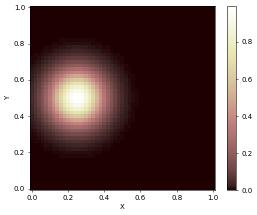

In [6]:
adv = AdvectionSolver(grid, fields_to_advect="topographic__elevation", **parameters)
imshow_grid(adv.grid, elev)

Velocity magnitude is 1.0
Duration is 0.4
Predicted distance is 0.4
Modeled distance is 0.4
Min/Max -7.90516220727542e-11 / 1.0552116404660585


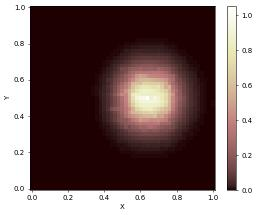

In [7]:
for _ in range(ntimesteps):
    adv.update(dt)
imshow_grid(adv.grid, elev)
calc_translation_distance(grid, elev, x0, y0, u, dt, ntimesteps)

### Raster grid with advection to the north

This time we'll show the *change* in value.

In [8]:
# Re-initialize and run again, this time with y-directed motion
ux = 0.0
uy = 1.0
vel[grid.horizontal_links] = ux
vel[grid.vertical_links] = uy

# Re-initialize the Gaussian bump
make_gaussian_bump(grid, elev, bump_width, center=[0.5,0.25])
elev0 = elev.copy()
try:
    adv.initial()
except:
    pass

Velocity magnitude is 1.0
Duration is 0.4
Predicted distance is 0.4
Modeled distance is 0.3538361202590827
Min/Max 3.500325319846224e-18 / 0.9950124791926823


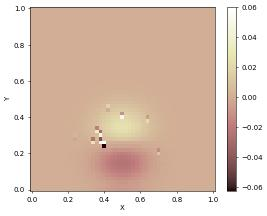

In [9]:
# for _ in range(ntimesteps):
adv.update(dt)
imshow_grid(adv.grid, elev - elev0)
calc_translation_distance(grid, elev, x0, y0, u, dt, ntimesteps)

### Raster grid with advection to the southwest

In [10]:
# Re-initialize and run again, this time with anti-x-directed motion
ux = -(1.5**0.5)
uy = -(1.5**0.5)
u = (ux * ux + uy * uy) ** 0.5

make_gaussian_bump(grid, elev, bump_width,center=[0.75,0.75])
elev0 = elev.copy()
vel[grid.horizontal_links] = ux
vel[grid.vertical_links] = uy
try:
    adv.initial()
except:
    pass

Velocity magnitude is 1.7320508075688772
Duration is 0.4
Predicted distance is 0.6928203230275509
Modeled distance is 0.2209072203437452
Min/Max 1.6311432834655015e-32 / 0.9025308465055252


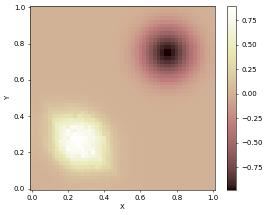

In [11]:
for _ in range(ntimesteps):
    adv.update(dt)
imshow_grid(adv.grid, elev - elev0)
calc_translation_distance(grid, elev, x0, y0, u, dt, ntimesteps)

### Raster grid with a non-uniform advection field

This example tests the component with a non-uniform advection field. For this test, we will shear the Gaussian bump by having $x$-directed motion that accelerates in the $y$ direction.

In [12]:
# Re-initialize and run again, this time with anti-x-directed motion
ux_max = 1.0
uy = 0.0
u = ux_max

make_gaussian_bump(grid, elev, bump_width)
elev0 = elev.copy()
vel[grid.horizontal_links] = (
    ux_max * grid.y_of_node[grid.node_at_link_tail[grid.horizontal_links]]
)
vel[grid.vertical_links] = 0.0
try:
    adv.initial()
except:
    pass

Velocity magnitude is 1.0
Duration is 0.4
Predicted distance is 0.4
Modeled distance is 0.48041648597857256
Min/Max -9.553989077485684e-11 / 0.9435093244118957


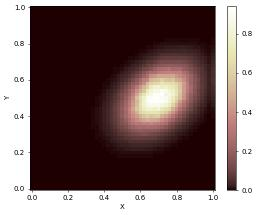

In [13]:
for _ in range(ntimesteps):
    adv.update(dt)
imshow_grid(adv.grid, elev)
calc_translation_distance(grid, elev, x0, y0, u, dt, ntimesteps)

### Case of divergent velocity

Here the velocity field diverges around $x=1/2$, which produces a rift in the midst of our Gaussian bump: a bit like Iceland might be without the volcanoes ...

In [14]:
# Identify places with positive vs. negative x-wise velocity
make_gaussian_bump(grid, elev, bump_width)
elev0 = elev.copy()
vel_is_neg = grid.x_of_node[grid.node_at_link_head] <= 0.5
vel[:] = 0.5
vel[vel_is_neg] = -0.5
vel[grid.vertical_links] = 0.0
try:
    adv.initial()
except:
    pass

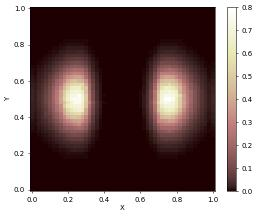

In [15]:
for _ in range(ntimesteps):
    adv.update(dt)
imshow_grid(adv.grid, elev)

## A rotating cone

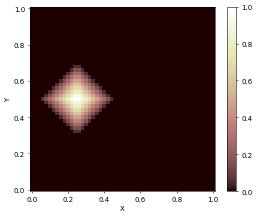

In [16]:
def make_cone(grid, field, width, center, radius):
    midx = 0.5 * np.amax(grid.x_of_node) - 0.5 + center[0]
    midy = 0.5 * np.amax(grid.y_of_node) - 0.5 + center[1]
    absDist = radius - ( abs(grid.x_of_node - midx) + abs(grid.y_of_node - midy) )
    field[:] = absDist[:] / max(absDist)
    field[absDist<0] = 0

make_cone(grid, elev, bump_width, center=[0.25,0.5], radius=0.2)

imshow_grid(adv.grid, elev)

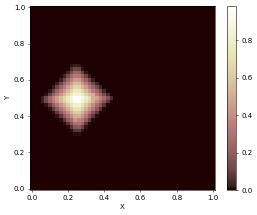

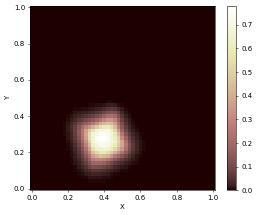

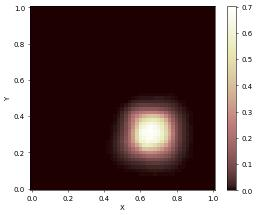

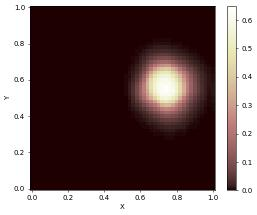

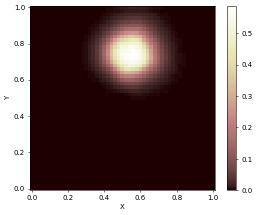

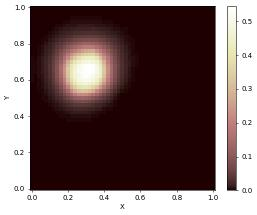

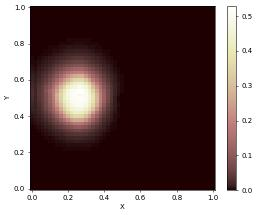

In [17]:
elev0 = elev.copy()

ux = 2 * np.pi
uy = 2 * np.pi
u = (ux * ux + uy * uy) ** 0.5
dt = c * dx / u

ntimesteps = int(1 / dt)

vel[grid.horizontal_links] = - np.pi * (
              grid.y_of_node[grid.node_at_link_tail[grid.horizontal_links]] +
              grid.y_of_node[grid.node_at_link_head[grid.horizontal_links]] - 1
)
vel[grid.vertical_links] = np.pi * (
              grid.x_of_node[grid.node_at_link_tail[grid.vertical_links]] +
              grid.x_of_node[grid.node_at_link_head[grid.vertical_links]] - 1
)

try:
    adv.initial()
except:
    pass

for i in range(ntimesteps):
    adv.update(dt)
    if i%400 == 0:
        plt.figure()
        imshow_grid(adv.grid, elev)

if dt*ntimesteps < 1-0.1*dt:
    adv.update(1-dt*ntimesteps)
plt.figure()
imshow_grid(adv.grid, elev)

Velocity magnitude is 8.885765876316732
Modeled distance is 0.041231056256176644
Min/Max -7.178200087373696e-11 / 0.5295487728709027


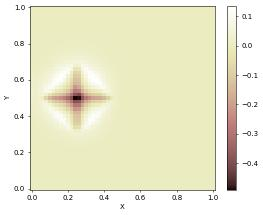

In [18]:
calc_translation_distance(grid, elev, 0.25, 0.5, u)
plt.figure()
imshow_grid(adv.grid, elev - elev0)